<a href="https://colab.research.google.com/github/mahadrafan/Class-pH-Prediction-Based-On-Soil-Components/blob/main/Prediksi_Klasifikasi_pH_Tanah_Berdasarkan_Indikator_Kimiawi_Tanah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediksi Klasifikasi pH Tanah Menggunakan Algoritma CatBoost Berdasarkan Indikator Kimiawi Tanah untuk Mendukung Pertanian Presisi

## Latar Belakang
### Tanah memiliki peran penting dalam ekosistem, di mana pH tanah bertindak sebagai variabel yang mengendalikan ketersediaan unsur hara dan produktivitas tanaman. Namun, metode analisis tanah konvensional seringkali terkendala oleh waktu, biaya, dan skalabilitas yang menghambat penerapan pertanian presisi. Mengingat kompleksitas interaksi antara sifat fisik dan kimia tanah—seperti kandungan bahan organik, kapasitas tukar kation (CEC), dan rasio unsur hara—analisa berbasis data diperlukan untuk memahami pola tersebut. Project ini menggunakan machine learning untuk memprediksi klasifikasi pH tanah secara efisien, sehingga dapat mendukung pengambilan keputusan agronomis yang lebih cepat dan berkelanjutan.





## Problem Statement
### Masalah yang ingin kita selesaikan adalah bagaimana cara kita mengatasi inefisiensi pengukuran manual pH tanah dengan mengembangkan model klasifikasi machine learning yang mampu memprediksi kondisi pH secara akurat berdasarkan indikator kimiawi di dalam tanah.

# Data Cleaning

In [3]:
# import library
!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
from google.colab import drive
import requests

warnings.filterwarnings('ignore')



In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_id = '1nGatyy-KTIJ4mDGBK0Pfya5Dz9cNhhai'
download_url_train = f'https://drive.google.com/uc?export=download&id={train_id}'

response = requests.get(download_url_train)
response.raise_for_status()

with open('/tmp/train.csv', 'wb') as f:
    f.write(response.content)

df_train = pd.read_csv('/tmp/train.csv')

test_id = '1Ivbr6ZSHsnQ1YPrjrgpAqdmA_nOOa5i0'
download_url_test = f'https://drive.google.com/uc?export=download&id={test_id}'
response = requests.get(download_url_test)
response.raise_for_status()

with open('/tmp/test.csv', 'wb') as f:
    f.write(response.content)

df_test = pd.read_csv('/tmp/test.csv')

display(df_train.head())

,ID,EC,OM,BD,P,SAND,SILT,CLAY,N,K,Ca,Mg,Na,CEC,SAR,ESP,Class.pH
0,31.12,1.4,2.4,1.4,21.0,65.5,16.7,17.8,0.0,0.4,3.1,2.9,0.4,8.9,0.1,0.0,Moderately acidic
1,2.00,0.4,1.3,1.3,10.5,18.2,30.0,51.8,0.1,2.1,54.1,3.4,5.9,40.7,0.2,0.1,Strongly alkaline
2,4.10,1.1,1.2,1.4,6.3,26.2,20.2,21.8,0.1,2.3,23.8,3.6,0.3,18.9,0.0,0.0,Moderately alkaline
3,6.00,0.4,3.2,1.3,4.2,32.9,26.0,41.1,0.1,1.8,91.5,10.6,0.2,36.3,0.0,0.0,Moderately alkaline
4,7.00,0.9,1.2,1.7,5.2,64.2,22.7,13.1,0.1,0.9,5.9,3.0,0.2,9.9,0.1,0.0,Moderately acidic


## Data Info

In [6]:
# rename column
new_column_names = {
    'EC': 'electrical_conductivity',
    'OM': 'organic_matter',
    'BD': 'bulk_density',
    'P': 'phosphorus',
    'N': 'nitrogen',
    'K': 'kalium',
    'SAND': 'sand',
    'SILT': 'silt',
    'CLAY': 'clay',
    'Class.pH': 'class_pH',
    'Ca': 'calsium',
    'Mg': 'magsium',
    'Na': 'natrium',
    'CEC': 'cation_exchange_capacity',
    'SAR': 'sodium_absorbtion_ratio',
    'ESP': 'exchangeable_sodium_percentage',
}

df_train.rename(columns=new_column_names, inplace=True)
df_test.rename(columns=new_column_names, inplace=True)

display(df_train.columns)
display(df_test.columns)

Index(['ID', 'electrical_conductivity', 'organic_matter', 'bulk_density',
       'phosphorus', 'sand', 'silt', 'clay', 'nitrogen', 'kalium', 'calsium',
       'magsium', 'natrium', 'cation_exchange_capacity',
       'sodium_absorbtion_ratio', 'exchangeable_sodium_percentage',
       'class_pH'],
      dtype='object')

Index(['ID', 'electrical_conductivity', 'organic_matter', 'bulk_density',
       'phosphorus', 'sand', 'silt', 'clay', 'nitrogen', 'kalium', 'calsium',
       'magsium', 'natrium', 'cation_exchange_capacity',
       'sodium_absorbtion_ratio', 'exchangeable_sodium_percentage'],
      dtype='object')

In [7]:
display(df_train.shape)

(3022, 17)

In [8]:
display(df_train.describe())

,ID,electrical_conductivity,organic_matter,bulk_density,phosphorus,sand,silt,clay,nitrogen,kalium,calsium,magsium,natrium,cation_exchange_capacity,sodium_absorbtion_ratio,exchangeable_sodium_percentage
count,3022.000000,3017.000000,3019.000000,3016.000000,2903.000000,3021.000000,3021.000000,3021.000000,3014.000000,3008.000000,3009.000000,3008.000000,3008.000000,3009.00000,3008.000000,3008.000000
mean,2421.431099,1.109195,3.124008,2.213316,22.845532,37.125654,22.062469,36.831314,0.502741,2.994927,21.056677,4.800233,6.007141,24.84563,0.179255,0.065392
std,1345.505169,3.324244,3.643582,5.015036,40.721598,19.183357,10.304526,16.862349,3.351938,7.071810,20.777854,4.456724,11.340342,17.39629,0.682404,0.216978
min,1.100000,0.000000,0.100000,0.500000,0.000000,0.800000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1276.250000,0.300000,1.500000,1.300000,5.200000,21.500000,15.100000,23.100000,0.100000,0.600000,4.900000,1.900000,0.400000,12.00000,0.000000,0.000000
50%,2370.500000,0.400000,2.300000,1.300000,12.100000,34.900000,21.300000,34.700000,0.100000,1.100000,15.000000,3.450000,0.900000,21.60000,0.000000,0.000000
75%,3601.750000,0.800000,3.600000,1.400000,26.450000,51.500000,28.000000,49.800000,0.100000,1.800000,32.300000,6.300000,2.500000,33.10000,0.100000,0.100000
max,4768.000000,65.400000,37.900000,31.120000,857.100000,100.000000,69.300000,83.200000,31.120000,31.120000,326.400000,34.200000,184.900000,128.70000,16.300000,7.300000


In [9]:
display(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3022 entries, 0 to 3021
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              3022 non-null   float64
 1   electrical_conductivity         3017 non-null   float64
 2   organic_matter                  3019 non-null   float64
 3   bulk_density                    3016 non-null   float64
 4   phosphorus                      2903 non-null   float64
 5   sand                            3021 non-null   float64
 6   silt                            3021 non-null   float64
 7   clay                            3021 non-null   float64
 8   nitrogen                        3014 non-null   float64
 9   kalium                          3008 non-null   float64
 10  calsium                         3009 non-null   float64
 11  magsium                         3008 non-null   float64
 12  natrium                         30

None

In [10]:
for col in ['class_pH']:
  if col in df_train.columns:
    display(f"Unique values for {col}:{df_train[col].unique()}")

"Unique values for class_pH:['Moderately acidic' 'Strongly alkaline' 'Moderately alkaline' 'Neutral'\n 'Strongly acidic' nan]"

## Missing Value

In [11]:
display(df_train.isnull().sum())

,0
ID,0
electrical_conductivity,5
organic_matter,3
bulk_density,6
phosphorus,119
sand,1
silt,1
clay,1
nitrogen,8
kalium,14


In [12]:
# handle missing value

numerical_cols_with_missing = df_train.select_dtypes(include=['float64', 'int64']).columns[df_train.select_dtypes(include=['float64', 'int64']).isnull().any()]

for col in numerical_cols_with_missing:
  median_val = df_train[col].median()
  df_train[col] = df_train[col].fillna(median_val)
  if col in df_test.columns:
    df_test[col] = df_test[col].fillna(median_val)

df_train.dropna(subset=['class_pH'], inplace=True)

display(df_train[numerical_cols_with_missing].isnull().sum())

display(df_test.isnull().sum())
display(df_train['class_pH'].isnull().sum())

,0
electrical_conductivity,0
organic_matter,0
bulk_density,0
phosphorus,0
sand,0
silt,0
clay,0
nitrogen,0
kalium,0
calsium,0


,0
ID,0
electrical_conductivity,0
organic_matter,0
bulk_density,0
phosphorus,0
sand,0
silt,0
clay,0
nitrogen,0
kalium,0


np.int64(0)

# EDA

## Target variable's distribution

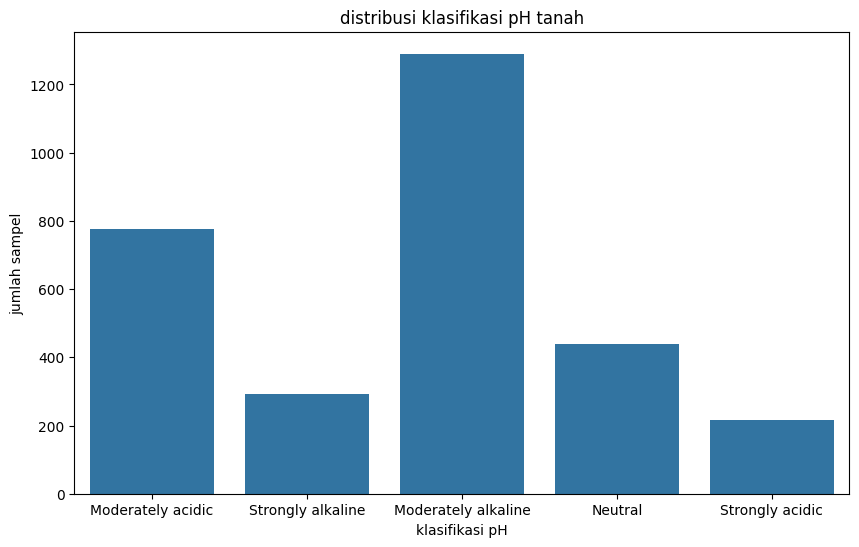

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x ='class_pH')
plt.title('distribusi klasifikasi pH tanah')
plt.xlabel('klasifikasi pH')
plt.ylabel('jumlah sampel')
plt.show()

## numerical feature's distribution

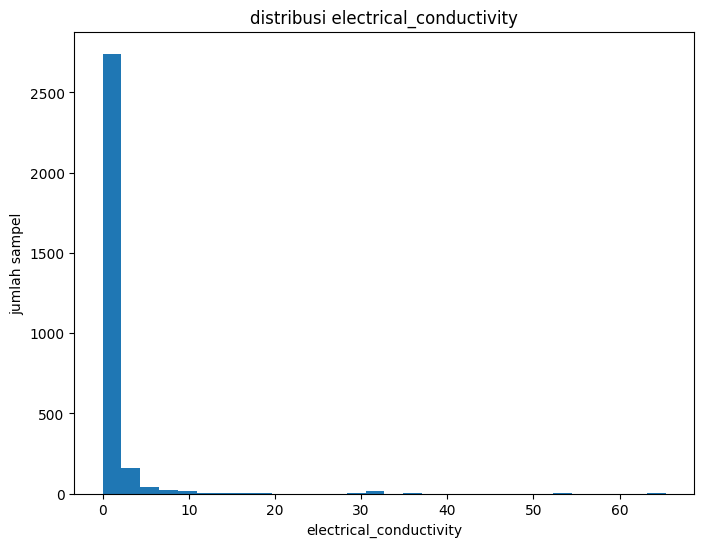

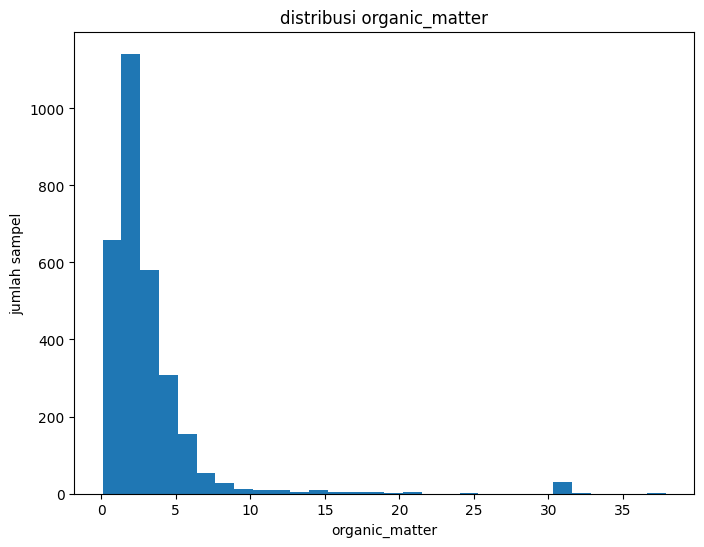

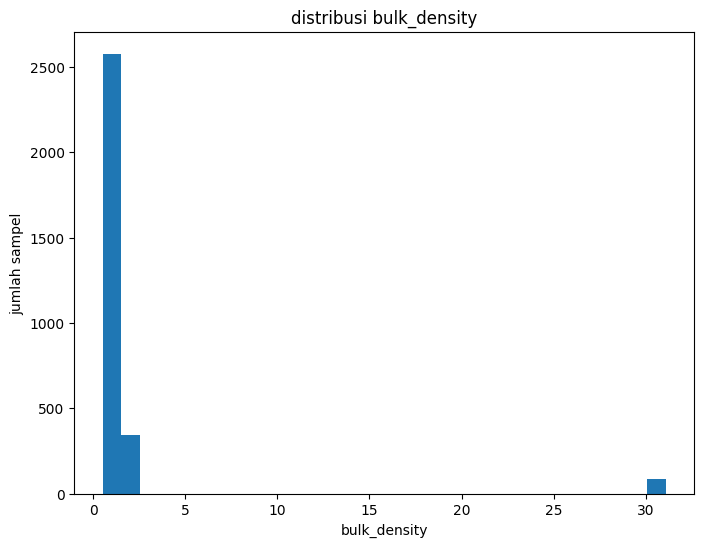

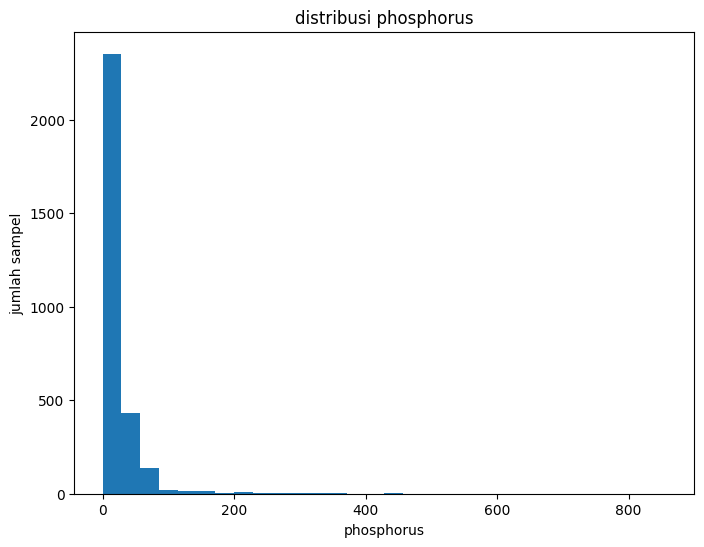

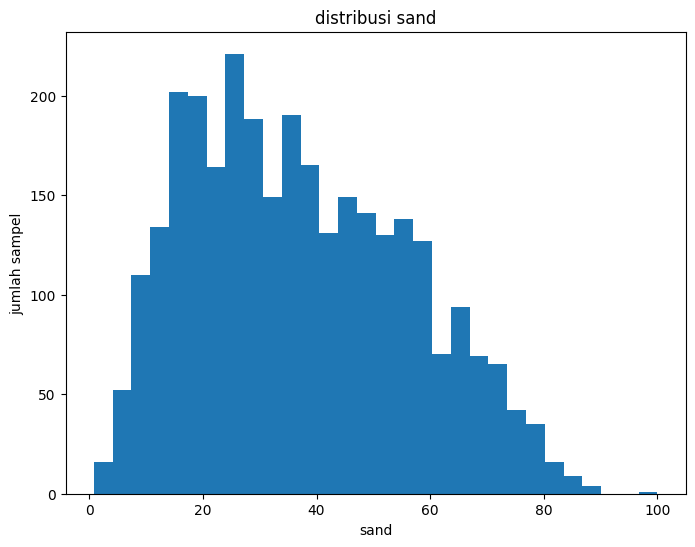

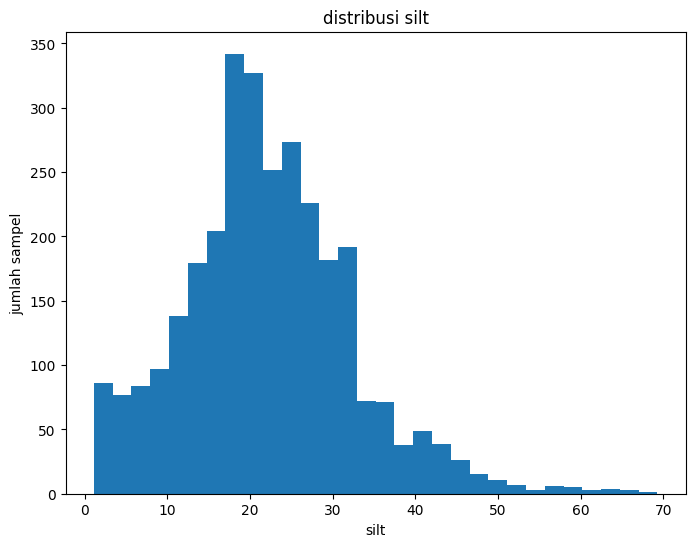

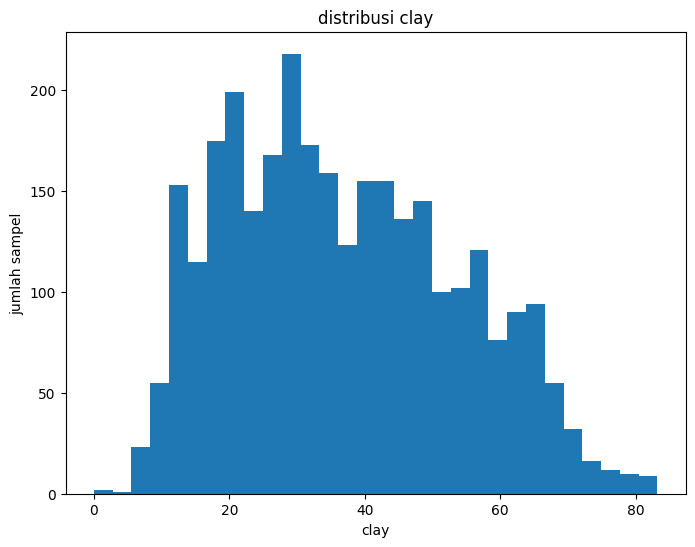

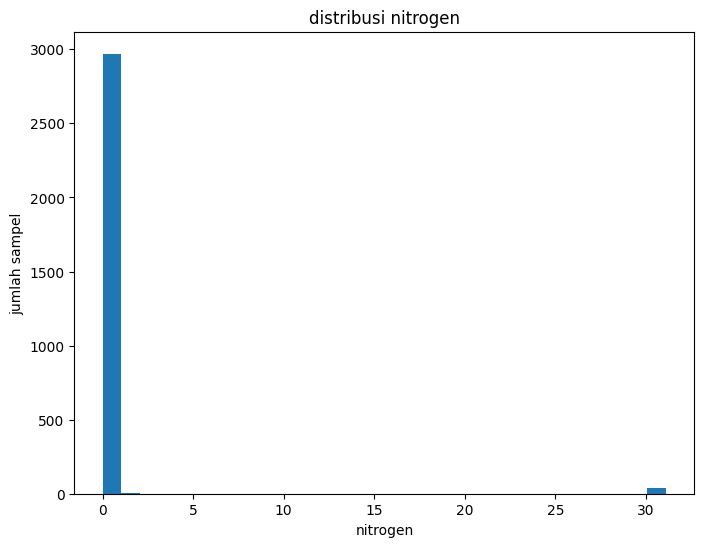

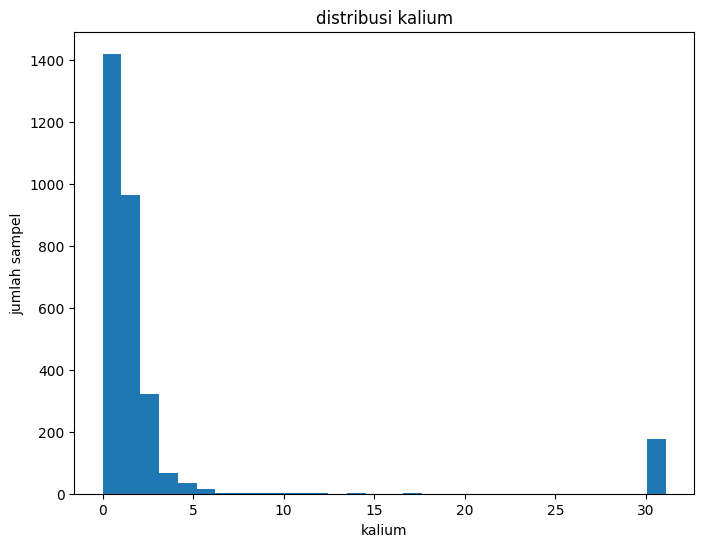

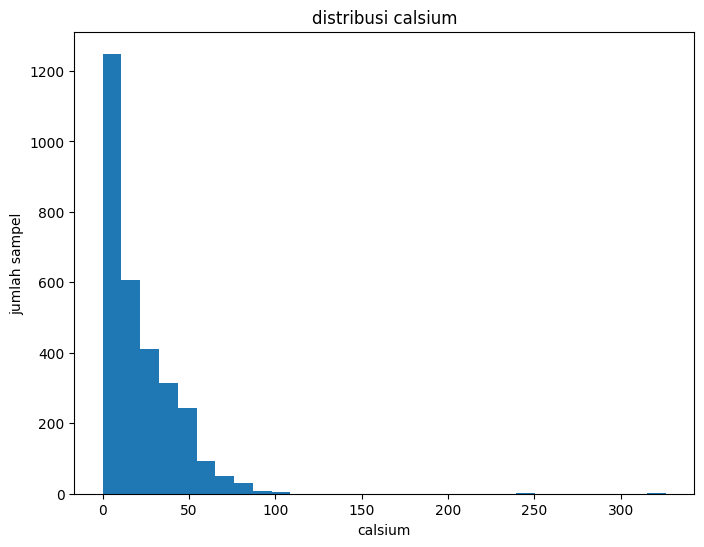

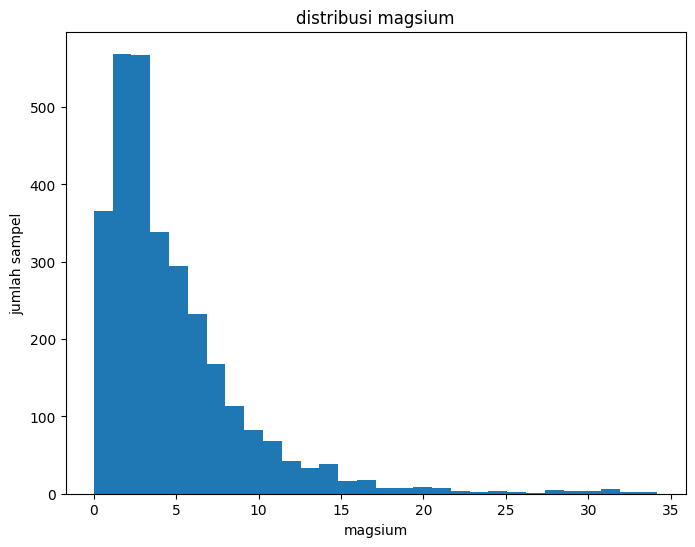

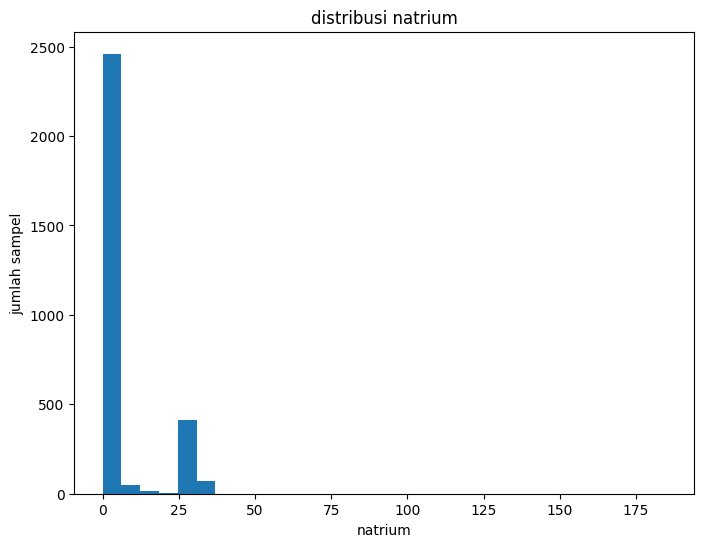

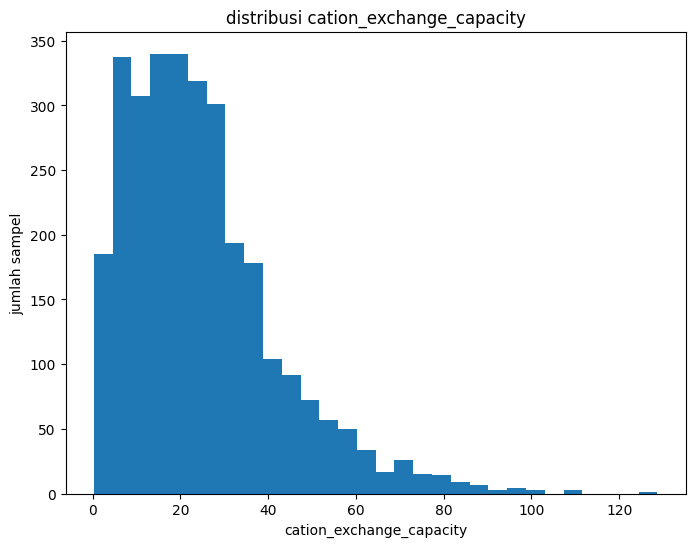

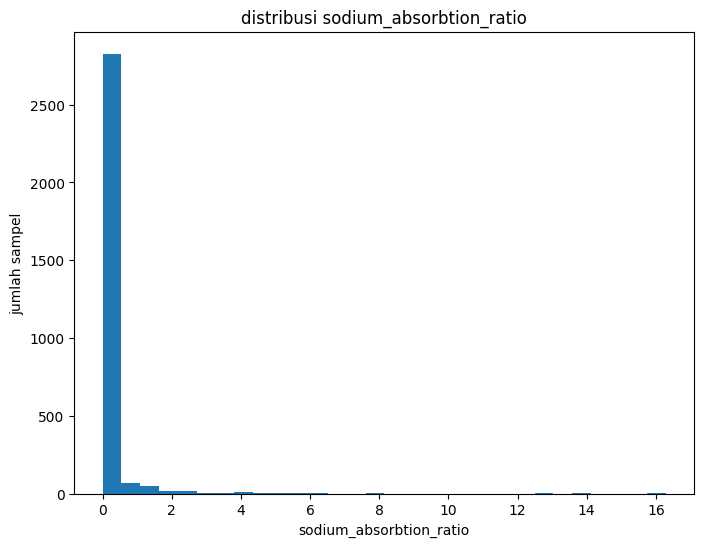

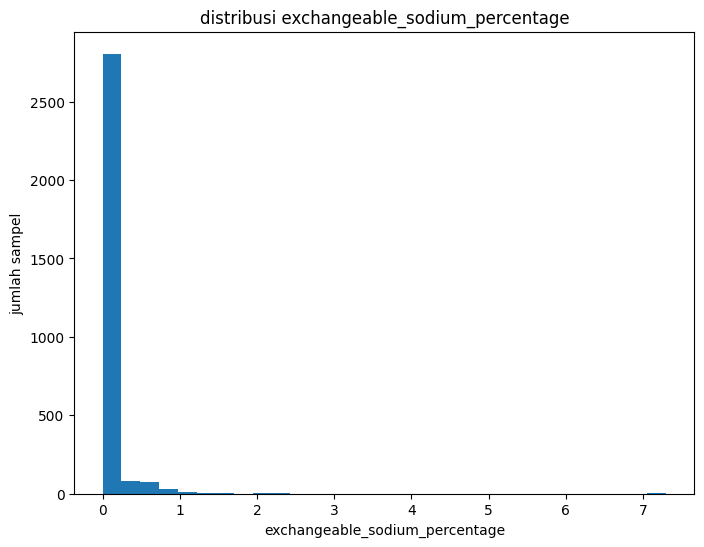

In [14]:
numerical_cols = df_train.select_dtypes(include=['float64', 'int64']).columns.drop('ID')

for col in numerical_cols:
  plt.figure(figsize=(8, 6))
  plt.hist(df_train[col], bins=30)
  plt.title(f"distribusi {col}")
  plt.xlabel(col)
  plt.ylabel('jumlah sampel')
  plt.show()

## hubungan target dengan numerical feature

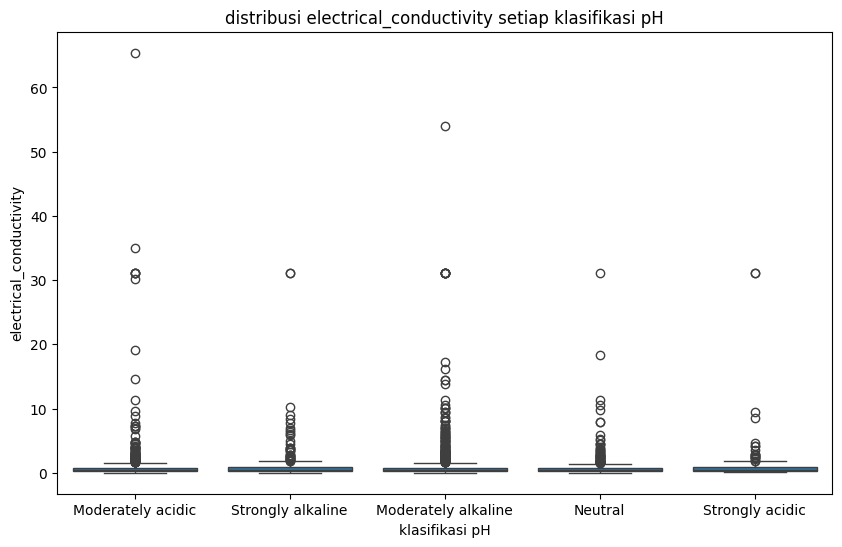

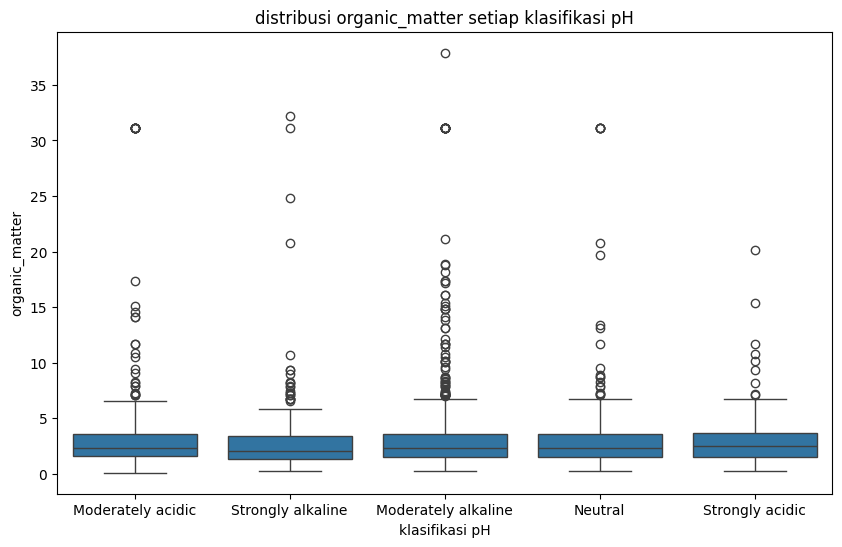

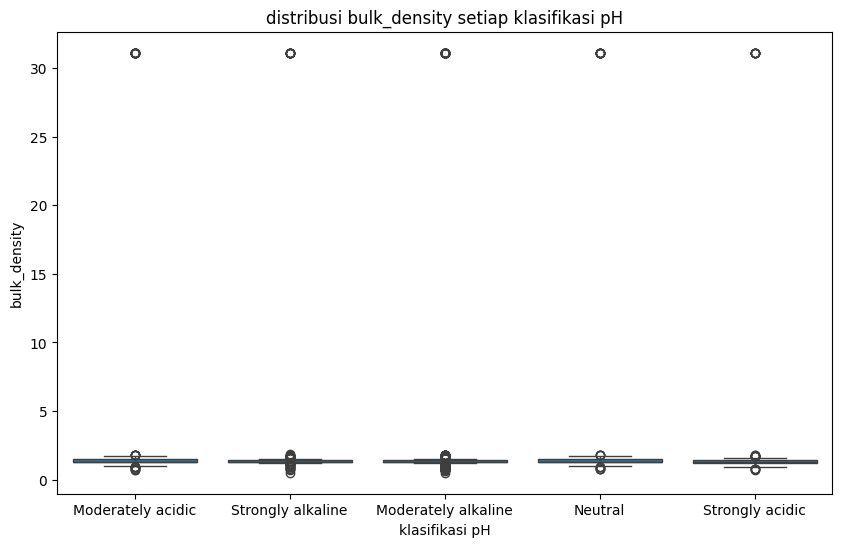

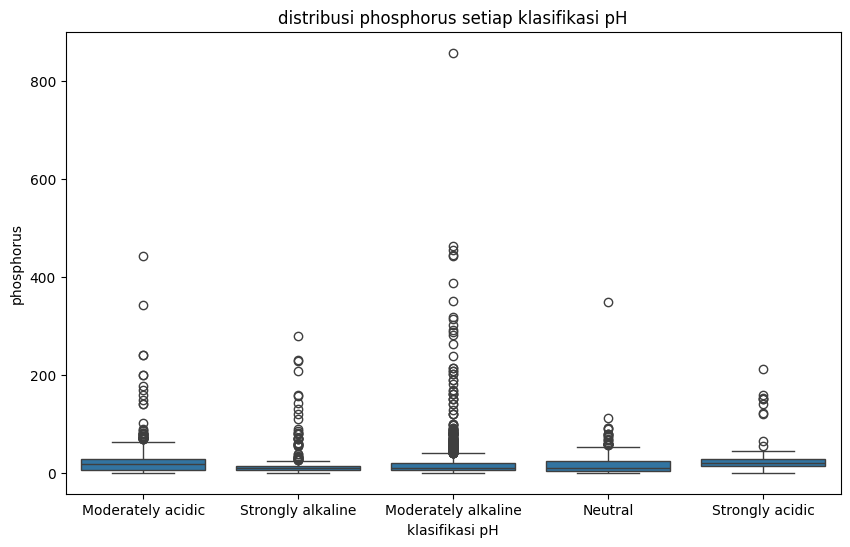

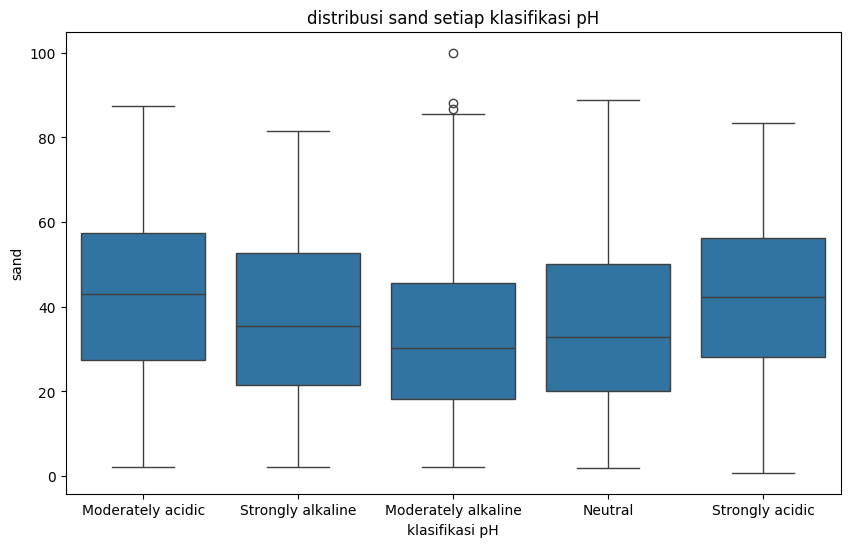

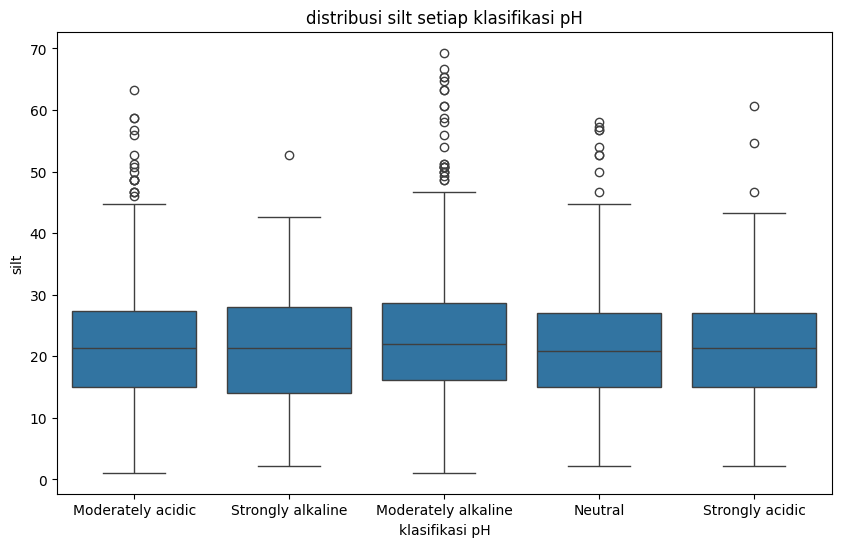

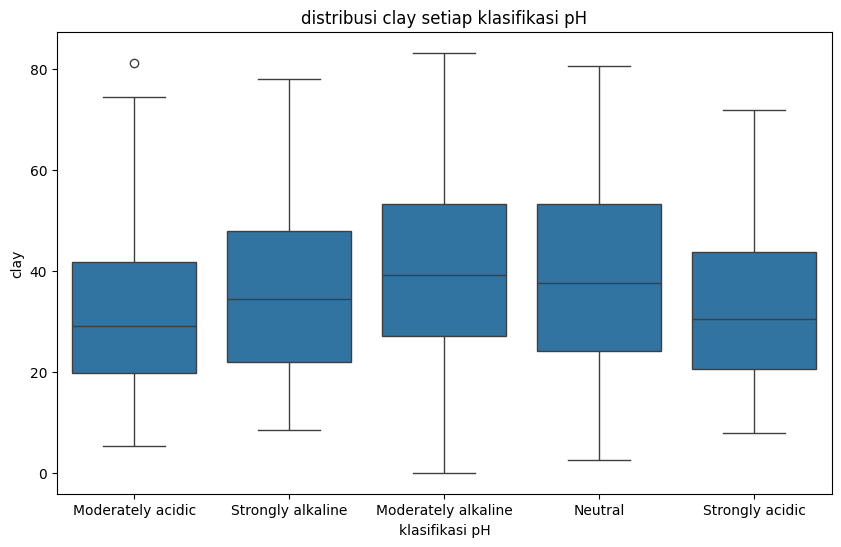

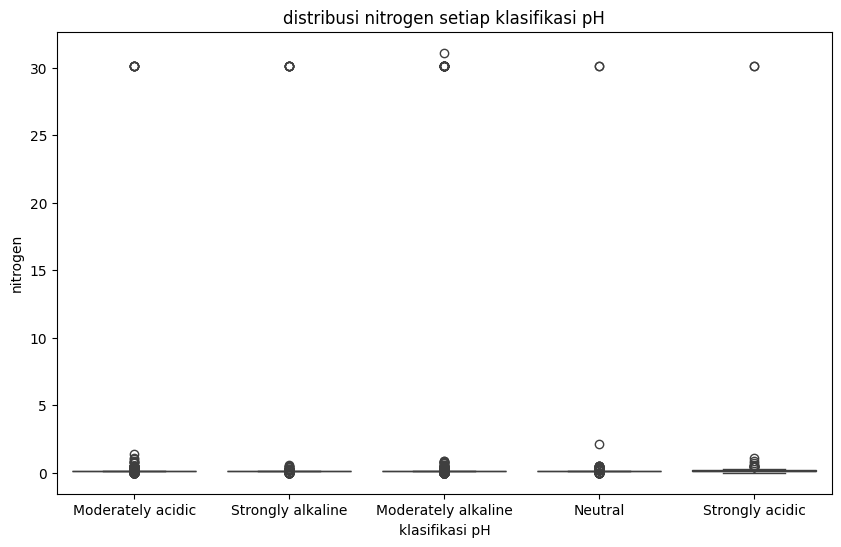

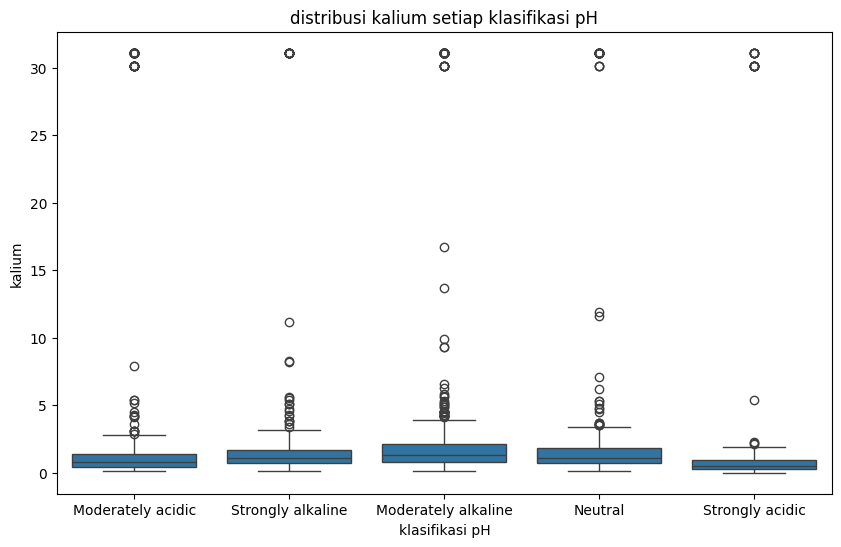

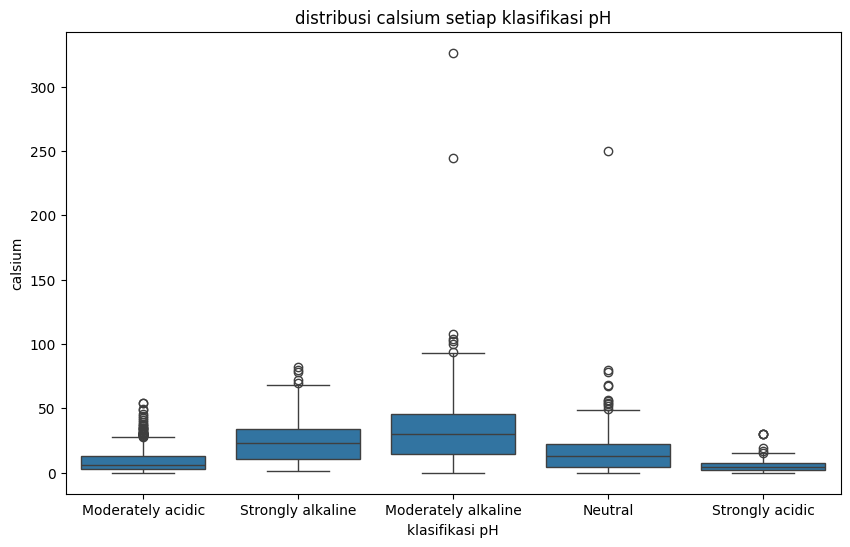

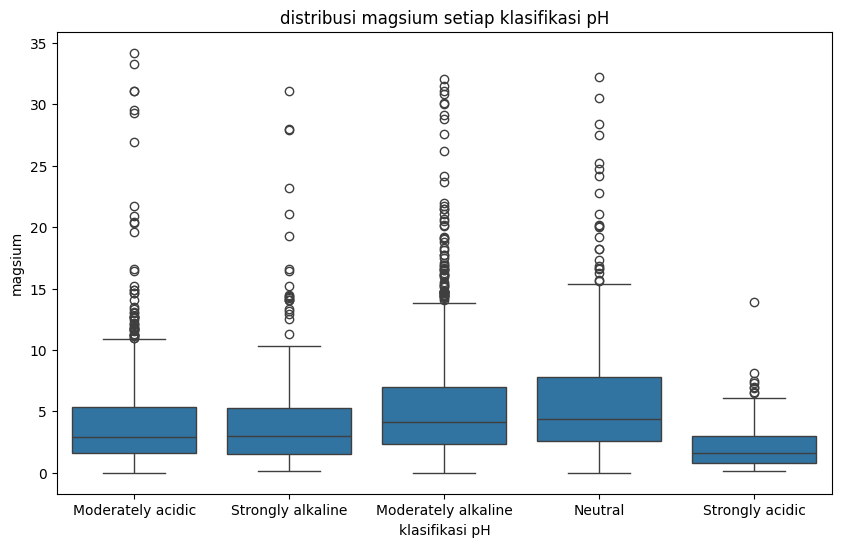

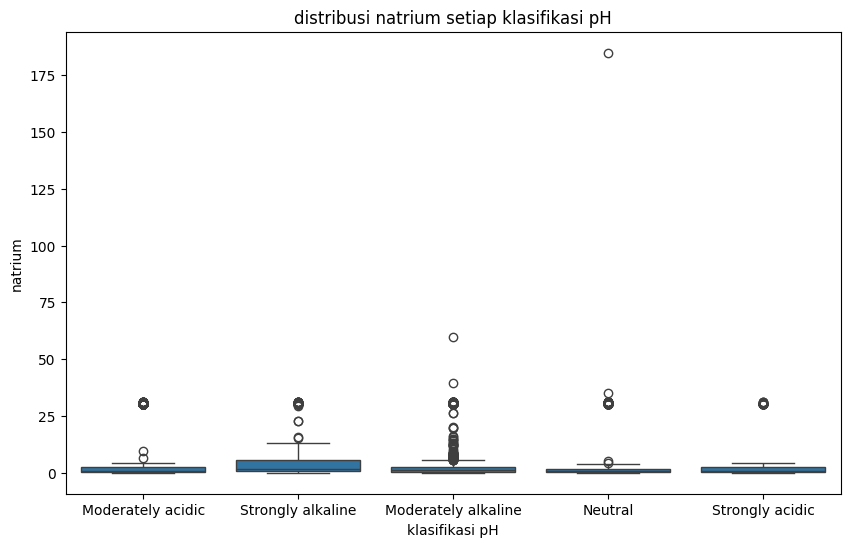

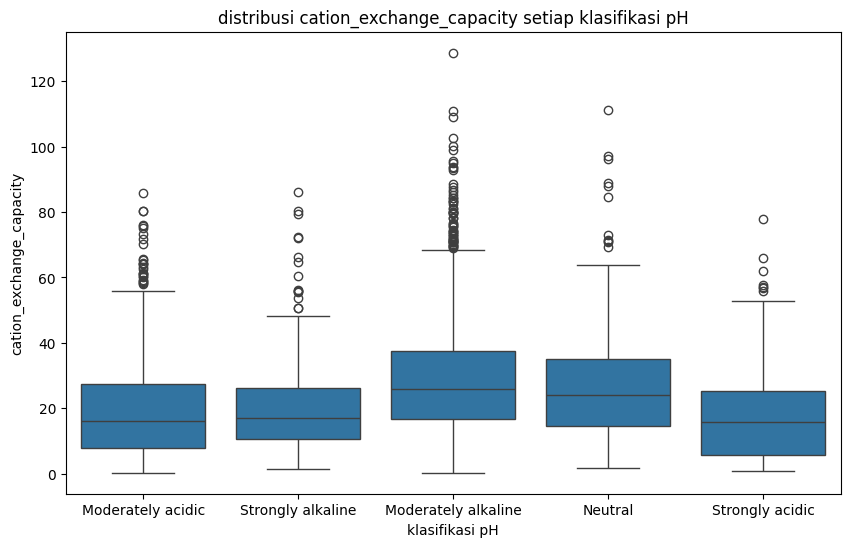

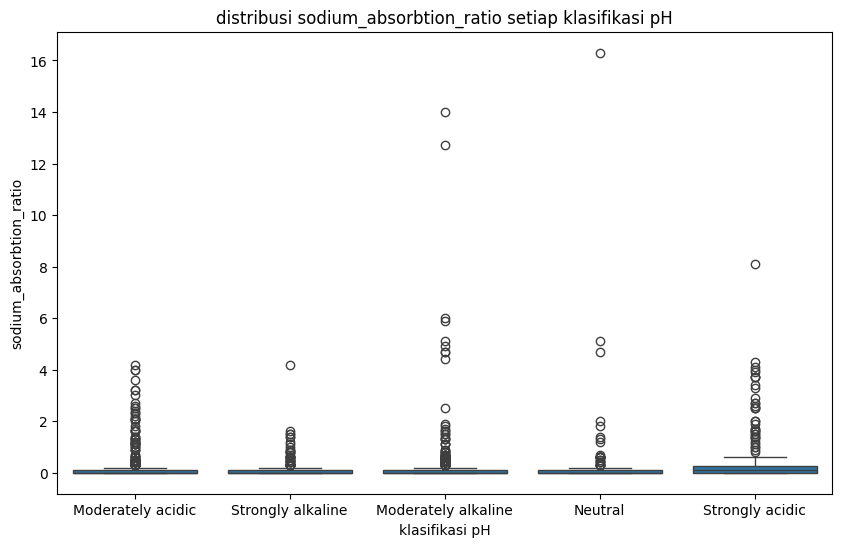

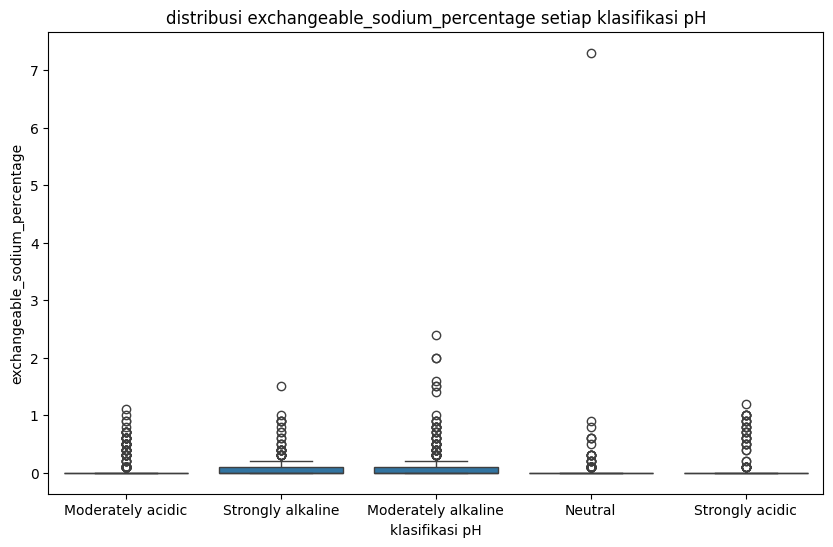

In [15]:
for col in numerical_cols:
  plt.figure(figsize=(10,6))
  sns.boxplot(data=df_train, x='class_pH', y=col)
  plt.title(f"distribusi {col} setiap klasifikasi pH")
  plt.xlabel('klasifikasi pH')
  plt.ylabel(col)
  plt.show()

## korelasi antar variabel

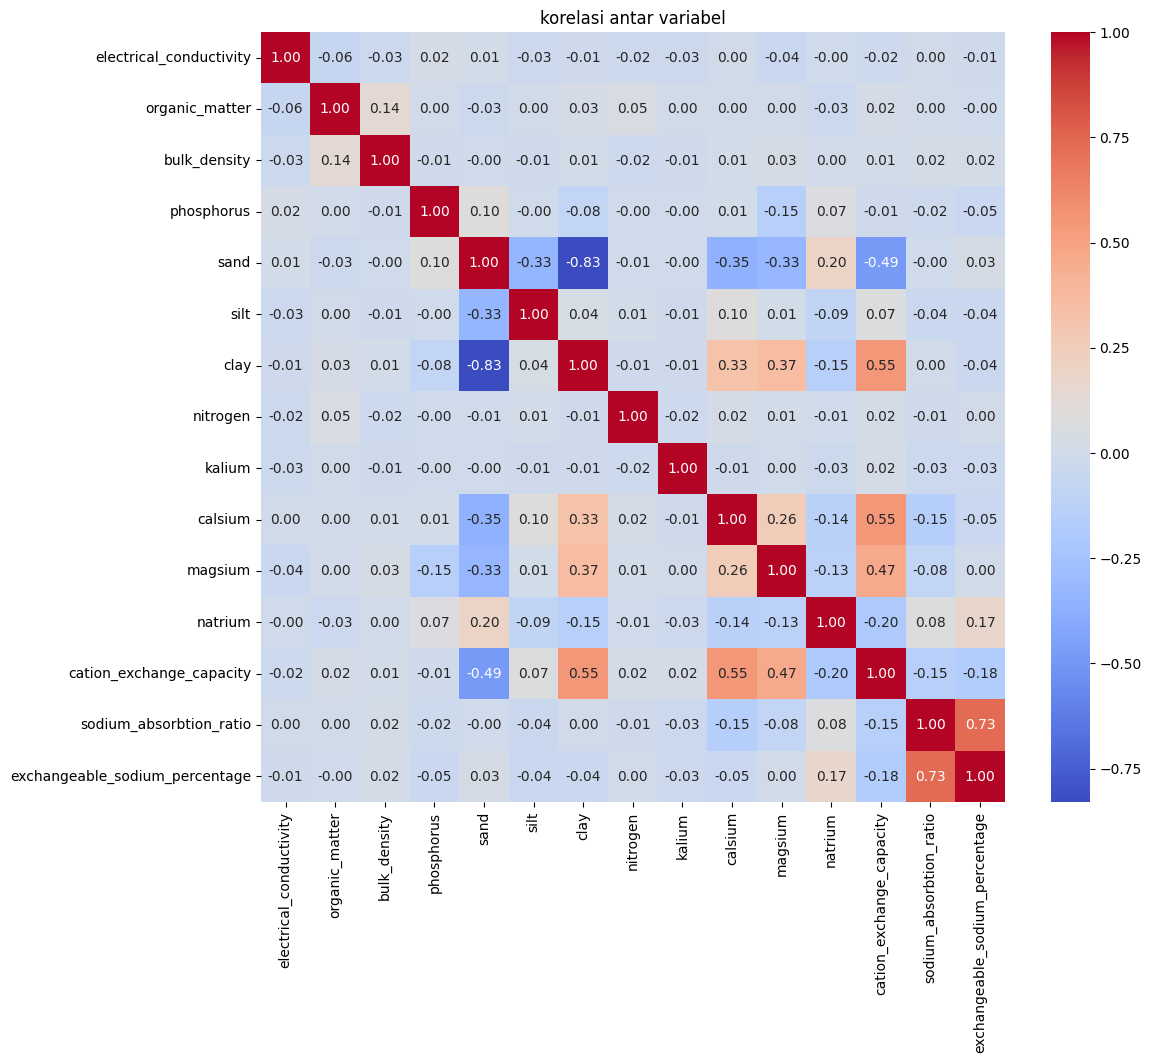

In [16]:
correlation_matrix = df_train[numerical_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("korelasi antar variabel")
plt.show()


# Data Loading

In [17]:
try:
    drive.mount('/content/drive')

    def download_file_from_gdrive(file_id, destination):
        download_url = f'https://drive.google.com/uc?export=download&id={file_id}'
        response = requests.get(download_url)
        response.raise_for_status()
        with open(destination, 'wb') as f:
            f.write(response.content)

    train_id = '1nGatyy-KTIJ4mDGBK0Pfya5Dz9cNhhai'
    download_file_from_gdrive(train_id, '/tmp/train.csv')
    train_df_raw = pd.read_csv('/tmp/train.csv')

    test_id = '1Ivbr6ZSHsnQ1YPrjrgpAqdmA_nOOa5i0'
    download_file_from_gdrive(test_id, '/tmp/test.csv')
    test_df_raw = pd.read_csv('/tmp/test.csv')

    print("Data loaded successfully from Google Drive.")

except Exception as e:
    print(f"FATAL ERROR during data loading: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully from Google Drive.


# Data Preprocessing and Feature Engineering

In [22]:
def process_data(train_df, test_df):
    """A full pipeline to clean, handle outliers, and create features."""

    train_ids = train_df['ID']
    test_ids = test_df['ID']

    train_target_raw = train_df['Class.pH']
    train_df = train_df.drop(columns=['ID', 'Class.pH'])
    test_df = test_df.drop(columns=['ID'])


    combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    combined_df.columns = [col.lower() for col in combined_df.columns]

    placeholder_values = [30.12, 31.12]
    combined_df.replace(placeholder_values, np.nan, inplace=True)

    for col in combined_df.columns:
        if combined_df[col].isnull().any():
            median_val = combined_df[col].median()
            combined_df[col].fillna(median_val, inplace=True)

    for col in combined_df.select_dtypes(include=np.number).columns:
        Q1, Q3 = combined_df[col].quantile(0.25), combined_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        combined_df[col] = combined_df[col].clip(lower=lower, upper=upper)

    epsilon = 1e-6
    base_cations = combined_df['ca'] + combined_df['mg'] + combined_df['k'] + combined_df['na']
    combined_df['base_saturation'] = base_cations / (combined_df['cec'] + epsilon)
    combined_df['ca_sat_ratio'] = combined_df['ca'] / (combined_df['cec'] + epsilon)
    combined_df['mg_sat_ratio'] = combined_df['mg'] / (combined_df['cec'] + epsilon)
    combined_df['k_sat_ratio'] = combined_df['k'] / (combined_df['cec'] + epsilon)
    combined_df['ca_mg_ratio'] = combined_df['ca'] / (combined_df['mg'] + epsilon)
    combined_df['mg_k_ratio'] = combined_df['mg'] / (combined_df['k'] + epsilon)
    combined_df['om_clay_ratio'] = combined_df['om'] / (combined_df['clay'] + epsilon)
    combined_df['sand_clay_ratio'] = combined_df['sand'] / (combined_df['clay'] + epsilon)
    combined_df['silt_clay_ratio'] = combined_df['silt'] / (combined_df['clay'] + epsilon)
    combined_df['n_p_ratio'] = combined_df['n'] / (combined_df['p'] + epsilon)
    combined_df['p_k_ratio'] = combined_df['p'] / (combined_df['k'] + epsilon)

    combined_df.replace([np.inf, -np.inf], 0, inplace=True)

    X = combined_df.iloc[:len(train_df)]
    X_test = combined_df.iloc[len(train_df):]

    print("Preprocessing and feature engineering complete.")
    return X, X_test, train_target_raw, test_ids

train_df_raw.dropna(subset=['Class.pH'], inplace=True)

X, X_test, y_raw, test_ids = process_data(train_df_raw.copy(), test_df_raw.copy())

Preprocessing and feature engineering complete.


## Feature Scaling and Encoding Target

In [23]:
encoder = LabelEncoder()
y = encoder.fit_transform(y_raw)
feature_names = X.columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

print("scaling and encoding complete")


scaling and encoding complete


# Building Model

In [31]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder = False, eval_metric = "mlogloss"),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results={}

for name, model in models.items():
  scores = cross_val_score(model, X_scaled, y, cv=cv, scoring="accuracy", n_jobs=-1)
  results[name] = scores.mean()
  print(f"{name}: Mean Accuracy = {scores.mean():.4f}(Std = {scores.std():.4f})")

  best_model_name = max(results, key=results.get)
print(f"\n best model: {best_model_name} with an accuracy of {results[best_model_name]:.4f}")

Random Forest: Mean Accuracy = 0.6109(Std = 0.0079)
XGBoost: Mean Accuracy = 0.5960(Std = 0.0083)
LightGBM: Mean Accuracy = 0.6059(Std = 0.0153)
CatBoost: Mean Accuracy = 0.6139(Std = 0.0134)

 best model: CatBoost with an accuracy of 0.6139


## Hyperparameter Tuning

In [40]:
param_grid_catboost = {
    'iterations': [200, 300],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3]
}

grid_search = GridSearchCV(
    estimator=CatBoostClassifier(random_state=42, verbose=0),
    param_grid=param_grid_catboost,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_scaled, y)
final_model = grid_search.best_estimator_

print(f"\n best parameters for {best_model_name}: {grid_search.best_params_}")
print(f" best cross-val score after tuning: {grid_search.best_score_:.4f} ")

Fitting 5 folds for each of 16 candidates, totalling 80 fits

 best parameters for CatBoost: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
 best cross-val score after tuning: 0.6202 


In [41]:
y_pred_train = final_model.predict(X_scaled)

target_names_str = [str(cls) for cls in encoder.classes_]
print(classification_report(y, y_pred_train, target_names=target_names_str))


                     precision    recall  f1-score   support

  Moderately acidic       0.67      0.86      0.75       776
Moderately alkaline       0.77      0.90      0.83      1290
            Neutral       0.73      0.43      0.54       438
    Strongly acidic       0.83      0.49      0.62       215
  Strongly alkaline       0.90      0.35      0.51       293

           accuracy                           0.74      3012
          macro avg       0.78      0.61      0.65      3012
       weighted avg       0.75      0.74      0.72      3012



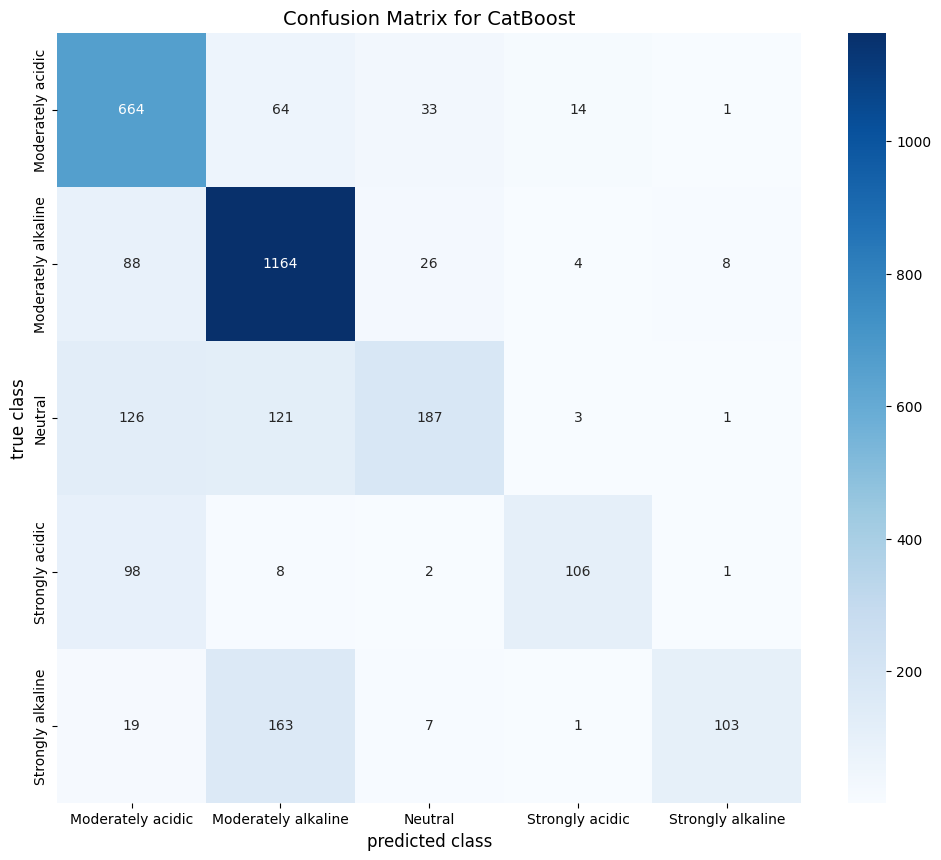

In [43]:
plt.figure(figsize=(12,10))
cm = confusion_matrix(y, y_pred_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_str, yticklabels=target_names_str)
plt.title(f"Confusion Matrix for {best_model_name}", fontsize = 14)
plt.xlabel('predicted class', fontsize=12)
plt.ylabel('true class', fontsize=12)
plt.savefig('confusion_matrix.png')


## Feature Importance Analysis

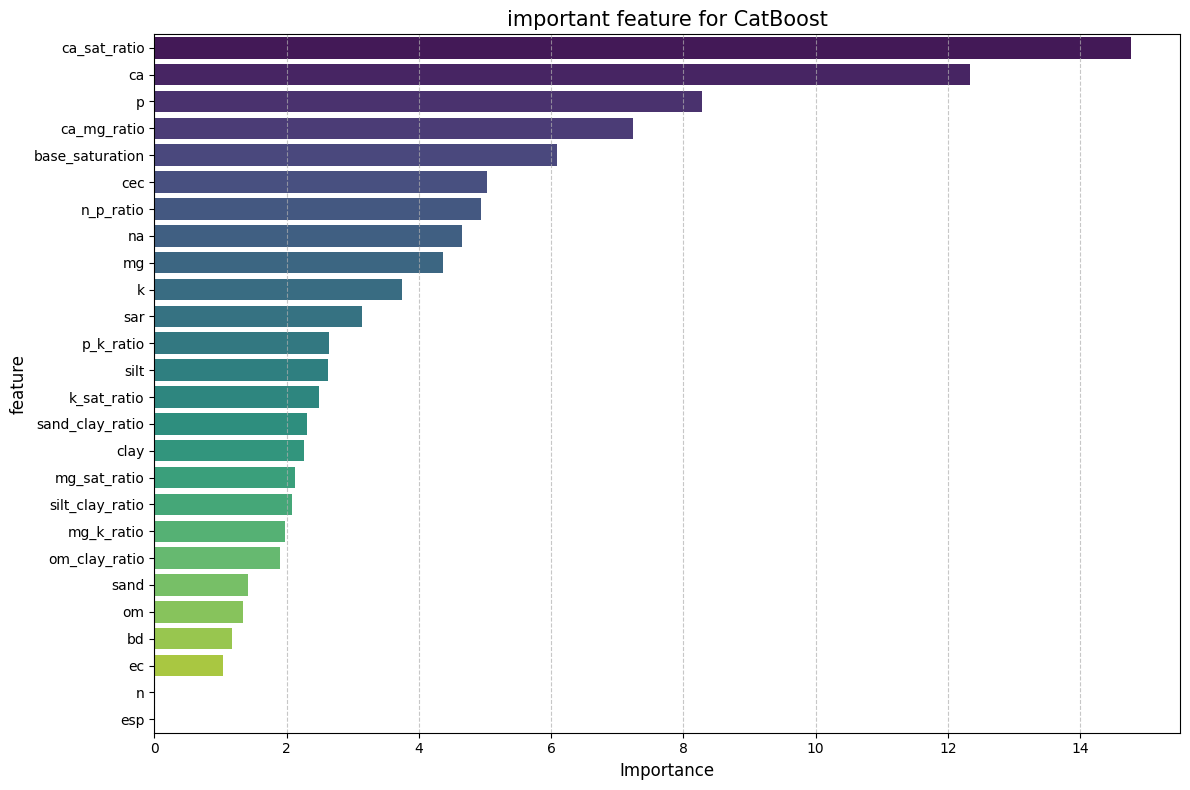

In [48]:
if hasattr(final_model, 'feature_importances_'):
  feature_importance = final_model.feature_importances_
else:
  feature_importance = final_model.get_feature_importance()

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data =importance_df, palette = 'viridis')
plt.title(f"important feature for {best_model_name}", fontsize=15)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


# Final Prediction

In [50]:
final_predictions_encoded = final_model.predict(X_test_scaled)
final_predictions = encoder.inverse_transform(final_predictions_encoded)

In [51]:
submission_df = pd.DataFrame({'ID': test_ids, 'Class.pH': final_predictions.flatten()})
submission_df.to_csv('submission.csv', index = False)


In [56]:
submission_df

,ID,Class.pH
0,4769.0,Moderately alkaline
1,4770.0,Moderately alkaline
2,4774.0,Strongly acidic
3,26.1,Moderately alkaline
4,4776.0,Moderately alkaline
...,...,...
1002,6044.0,Moderately alkaline
1003,6045.0,Moderately alkaline
1004,6046.0,Moderately alkaline
1005,6047.0,Moderately acidic


# Conclusion

- hasil analisis membuktikan bahwa model machine learning CatBoost dapat memprediksi tingkat pH tanah berdasarkan unsur kandungan tanah secara cukup akurat hingga mencapai 74%. Hal ini membuktikan bahwa data sifat kimia dan fisik tanah dapat digunakan untuk mengestimasi tingkat keasaman
tanah, sehingga proses penilaian pH dapat dipercepat dan didukung oleh data.

- selain itu, terdapat fitur rekayasa seperti rasio Ca:Mg dan base saturation yang terbukti memberikan informasi prediktif yang kuat. Fitur-fitur ini sejalan dengan pemahaman ilmiah bahwa keseimbangan kation basa, kapasitas tukar kation, dan ketersediaan fosfor adalah determinan utama reaksi tanah (pH).


- Hal ini dapat membantu petani dan konsultan pertanian dalam mengetahui tingkat pH tanah lebih cepat dan efisien tanpa menunggu hasil dari pengukuran tingkat pH tanah secara manual atau uji laboratorium khusus.

- Penggunaan model juga diharapkan dapat membantu pengambilan keputusan seperti rekomendasi pengapuran, pemupukan, atau pemilihan komoditas yang sesuai dengan kondisi pH tanah lebih efisien.

# What to improve
- mengumpulkan data yang lebih luas seperti faktor geografis dan penggunaan citra satelit yang mendukung variabel input.
- melakukan pengujian metode penyeimbangan data agar dapat mengatasi kelas pH yang jarang.
